In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

1. Прочтем и распарсим по типу датафрейм, предварительно, заменив корявые данные, мешающие преобразованию в формат

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv(r'F:\Downloads\case.csv', sep=';', dtype={"vstrechpredst":"float64", "credit":"float64", "avans":"float64", "electron":"float64",  "nal":"float64"
                                                               , "cost":"float64", "price":"float64", "amount":"float64"}
                 , parse_dates=['d_date'], date_parser=dateparse, na_values=["--", '""1"""'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 15 columns):
receiptid        int64
kkt_sn           int64
d_date           datetime64[ns]
name             object
amount           float64
unit             object
price            float64
cost             float64
nal              float64
electron         float64
avans            float64
credit           float64
vstrechpredst    float64
Тип региона      object
Имя региона      object
dtypes: datetime64[ns](1), float64(8), int64(2), object(4)
memory usage: 1.1+ GB


Посмотрим на пустые строки 

In [4]:
for col in df.columns:
    dd = df.loc[pd.isnull(df[col])==1].shape[0] 
    if dd > 0: print(col, dd)

name 15
amount 34
unit 7982117
price 23
cost 40
nal 8
electron 4
avans 4
credit 4
vstrechpredst 4
Тип региона 21035
Имя региона 21035


Сделаем замену для пустых регионов и единицы измерения товара, остальные строки удалим

In [5]:
df['Тип региона'].fillna('-', axis=0, inplace=True)
df['Имя региона'].fillna('-', axis=0, inplace=True)
df['unit'].fillna('-', axis=0, inplace=True)

In [6]:
df.dropna(axis=0, inplace=True)

Посмотрим на временной интервал - дан 2018 год 6,7,8 месяцы

In [7]:
df['d_date'].dt.month.value_counts()

6    5538961
7    4298429
8     162565
Name: d_date, dtype: int64

In [8]:
df.loc[df['d_date'].dt.month==8]['d_date'].dt.day.value_counts()

1    162565
Name: d_date, dtype: int64

Так как из 8 месяца только 1 день, то будем рассматривать только 6 и 7 месяцы

In [9]:
df = df.loc[df['d_date'].dt.month!=8]

Сгруппируем продажи по регионам и чекам и посмотрим на соотношение оплаты по карте к оплате наличными

In [10]:
df_type_cost = df.loc[~df['Имя региона'].isin(['-', '0'])].groupby(
    ['Имя региона','receiptid'])[['nal', 'electron']].mean().reset_index()
df_type_cost['nal'] = df_type_cost['nal'].astype(bool)
df_type_cost['electron'] = df_type_cost['electron'].astype(bool)
df_type_cost_reg = df_type_cost.groupby('Имя региона')[['nal', 'electron']].sum().reset_index()
df_type_cost_reg['electron/nal'] = 100 * (df_type_cost_reg['electron'] / df_type_cost_reg['nal'])

Выведем топ-5 по оплате картой и топ 5 по оплате наличными

In [11]:
df_type_cost_reg.sort_values('electron/nal', ascending=False).head(5)

,Имя региона,nal,electron,electron/nal
30,Коми,41137.0,47848.0,116.313781
60,Саха /Якутия/,5442.0,5691.0,104.575524
64,Северная Осетия - Алания,2141.0,1934.0,90.331621
70,Томская,20890.0,17834.0,85.370991
44,Мурманская,4172.0,3501.0,83.916587


In [12]:
df_type_cost_reg.sort_values('electron/nal', ascending=False).tail(5)

,Имя региона,nal,electron,electron/nal
21,Кабардино-Балкарская,37467.0,284.0,0.758000
15,Дагестан,11786.0,2.0,0.016969
80,Чеченская,639.0,0.0,0.000000
19,Ингушетия,69.0,0.0,0.000000
82,Чукотский,678.0,0.0,0.000000


Слегка почистим преобразуем названия товаров и посмотрми на категории

In [13]:
df = df.loc[~df['Имя региона'].isin(['-', '0'])]

In [14]:
df['name'] = df['name'].str.lower().str.findall(r'[а-яА-я-]{3,}').apply(lambda x: ", ".join(x))

In [15]:
df['name'].value_counts()

товар                                                                                         2465501
                                                                                               427810
продукты                                                                                       292146
хлебо-булочные, изделия                                                                        147477
сигареты                                                                                       111569
продажа, свободной, цене                                                                       108985
товар, сумму                                                                                   107130
продукты, питания                                                                              103948
хлебобулочные, изделия                                                                          95704
хлеб                                                                              

Так как размечать категории товаров довольно длительно, возьмем и разметим несколько категорий лидеров и случайные и затем проанализируем:
- хлеб
- сигареты
- бензин
- пуховики

In [16]:
df['hleb'] = df['name'].str.findall(r'хлеб').apply(lambda x : ', '.join(x))
df.loc[df.hleb!='']['name'].value_counts()

хлебо-булочные, изделия                                  147477
хлебобулочные, изделия                                    95704
хлеб                                                      90553
хлебобулочные, изделия, ассорт                            83818
хлеб, хлебобулочные                                       27833
хлебные, изделия                                           8716
хлеб, пшенич, формовой                                     8440
хлеб, дарницкий                                            7350
хлебо-будочные, изделия                                    6192
хлебобулочная, продукция                                   5873
хлеб, сорт                                                 5638
хлеб, хлебобулочные, изделия                               5300
хлеб, донской, кирпич                                      4429
хлеб, выпечка                                              4234
хлеб, слободской                                           3554
хлеб, ржано-пшеничный, дан              

In [17]:
df['sig'] = df['name'].str.findall(r'табач|сига|винст|парламе').apply(lambda x : ', '.join(x))
df.loc[df.sig!='']['name'].value_counts()

сигареты                                              111569
табачные, изделия                                      82202
сигареты, мрц, руб                                      4761
винстон, синий                                          2452
сигареты, яркий                                         2358
сигареты, кент                                          1053
сигареты, винстон                                       1052
сигареты, мрц                                            865
винстон, сереб, пачка                                    756
табачные, изделия, сопутствуюцие, товары                 744
винстон, синяя, пачка                                    679
винстон                                                  614
сигареты, ява, золотая, класс                            606
сигареты, кнопка, мандарин                               554
винстон, серебро                                         539
сигареты, ява, золотая, классическая                     528
сигареты, филипп, морисс

In [18]:
df['benz'] = df['name'].str.findall(r'бензин|аи-|топлив|кероси|дизел').apply(lambda x : ', '.join(x))
df.loc[df.benz!='']['name'].value_counts()

аи-                                                                                                  28134
аи-, опт-к                                                                                            3473
бензин, аи-                                                                                           2513
бензин                                                                                                1453
дизельное, топливо                                                                                     272
трк, регуляр-, аи-                                                                                     266
диз, топливо, евро                                                                                      64
трк, премиум, евро-, аи-                                                                                52
трк, топливо, дизельное, дт-а-к                                                                         43
заправка, газ, бензин                

In [19]:
df['puh'] = df['name'].str.findall(r'пухови').apply(lambda x : ', '.join(x))
df.loc[df.puh!='']['name'].value_counts()

пуховик                                                          6133
пуховик, жен                                                       89
пуховик, муж                                                       16
одежда, женская, одежда, женская, пуховик, женский, зима, арт       3
арт-, пуховик, хаки                                                 3
пальто, пуховик                                                     2
одежда, женская, одежда, женская, пуховик, женский, зима            2
арт-, пуховик, пудра                                                1
шампунь, для, пуховиков                                             1
Name: name, dtype: int64

Посмотрим на хлеб

In [20]:
df_hleb = df.loc[(df.hleb!='') & (df.cost>2)  & (df.cost<10e6)].groupby(['Имя региона', 'receiptid']
                                           )['cost'].sum().reset_index().groupby(['Имя региона'])['cost'].agg({'min', np.median, 'max', 'sum'}
                                                                                                             ).sort_values('median', ascending=False).reset_index()

In [21]:
df_hleb.head()

,Имя региона,min,sum,median,max
0,Крым,16.0,879426.0,1200.0,11200.0
1,Татарстан,22.0,1161.0,562.0,577.0
2,Красноярский,15.0,516441.3,520.0,9696.0
3,Удмуртская,444.0,444.0,444.0,444.0
4,Тамбовская,22.0,95177.0,200.0,2900.0


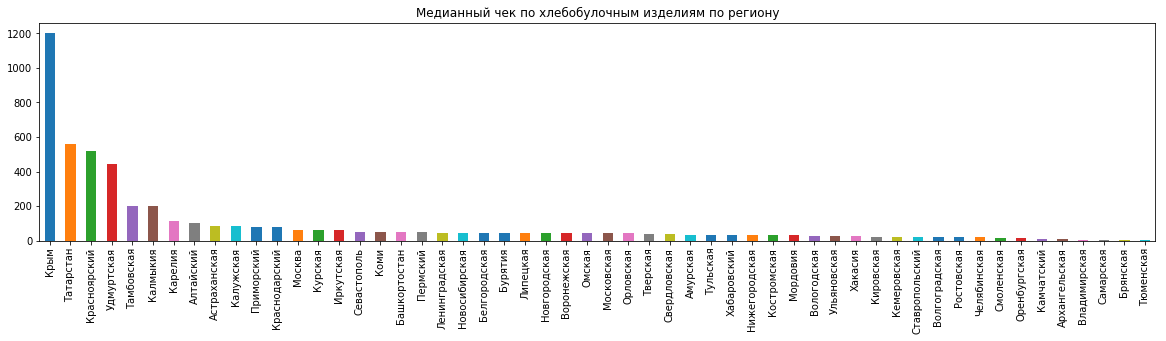

In [22]:
ax = df_hleb['median'].plot(kind='bar', figsize=(20,4), title='Медианный чек по хлебобулочным изделиям по региону');
ax.set_xticks(df_hleb.index);
ax.set_xticklabels(df_hleb['Имя региона'], rotation=90);

Видим, что в Крыму очень большая медиана, посмотрим, как покупали хлеб в Крыму по дням

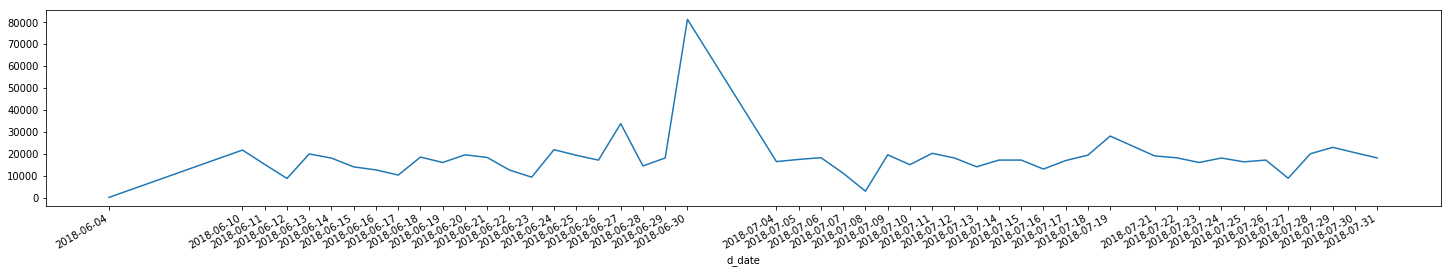

In [23]:
df_krim = df.loc[(df.hleb!='')  & (df['Имя региона']=='Крым')].groupby(['d_date', 'receiptid'])['cost'].sum().reset_index().groupby('d_date')['cost'].sum()
ax = df_krim.plot(figsize=(25,4));
ax.set_xticks(df_krim.index);

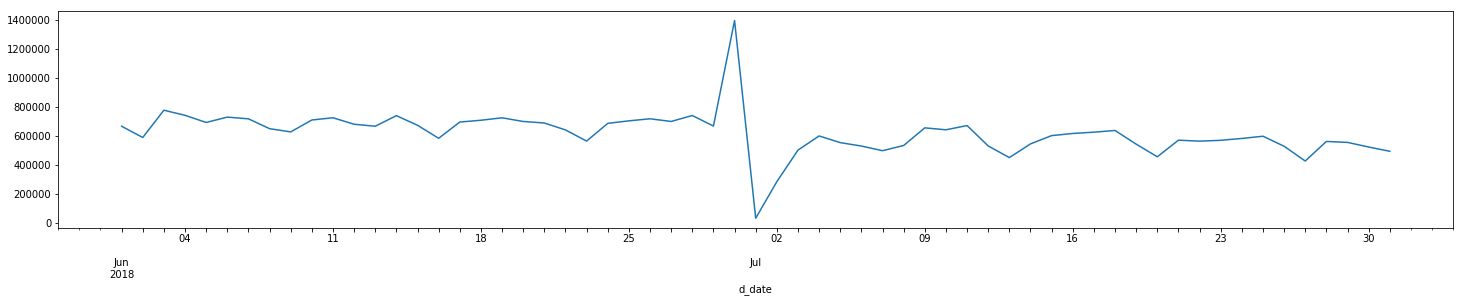

In [24]:
df_hleb_all = df.loc[(df.hleb!='')  & (df['Имя региона']!='Крым') & (df.cost<10e3)].groupby(['d_date', 'receiptid'])['cost'].sum().reset_index().groupby('d_date')['cost'].sum()
ax = df_hleb_all.plot(figsize=(25,4));
ax.set_xticks(df_hleb_all.index);

Видим, что отсутствуют некоторые дни, а также что 30.06.2018 большой скачок в покупке хлебных изделий и затем отсутствие данной категории покупок до 04.07

Посмотрим на чеки от 30.06 и увидим 23 чека по 2000 и 28 чеков по 1200 , дубликаты это или нет, по данным полям не понять, т.к. поле id уникальное.

In [25]:
df.loc[(df.hleb!='')  & (df['Имя региона']=='Крым') & (df['d_date']=='2018-06-30')].groupby(['d_date', 'price'])['cost'].agg({'sum', 'count'}).reset_index()

,d_date,price,sum,count
0,2018-06-30,45.0,45.0,1
1,2018-06-30,700.0,700.0,1
2,2018-06-30,1000.0,1000.0,1
3,2018-06-30,1200.0,33600.0,28
4,2018-06-30,2000.0,46000.0,23


Посмотрим на сигареты

In [26]:
df_sigaret = df.loc[(df.sig!='')].groupby(['Имя региона', 'receiptid']
                                           )['cost'].sum().reset_index().groupby(['Имя региона'])['cost'].agg({'min', np.median, 'max', 'sum'}
                                                                                                             ).sort_values('median', ascending=False).reset_index()
df_sigaret.head()

,Имя региона,min,sum,median,max
0,Хабаровский,0.0,1467870.89,1862.50,24580.00
1,Орловская,120.0,221921.19,1380.82,19637.95
2,Московская,0.0,4629476.10,242.00,35277.00
3,Липецкая,1.0,362482.50,236.00,9200.00
4,Саратовская,1.0,3942.00,202.50,500.00


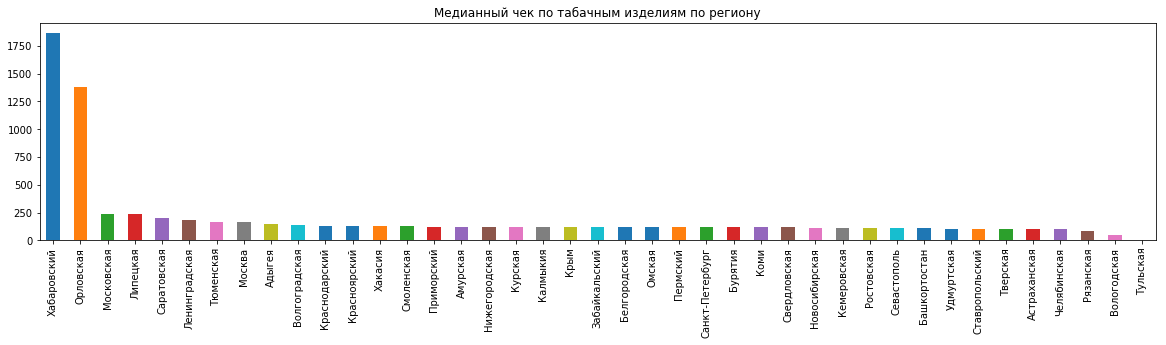

In [27]:
ax = df_sigaret['median'].plot(kind='bar', figsize=(20,4), title='Медианный чек по табачным изделиям по региону');
ax.set_xticks(df_sigaret.index);
ax.set_xticklabels(df_sigaret['Имя региона'], rotation=90);

Посмотрим на все регионы без Хабаровска и отдельно на Хабаровск

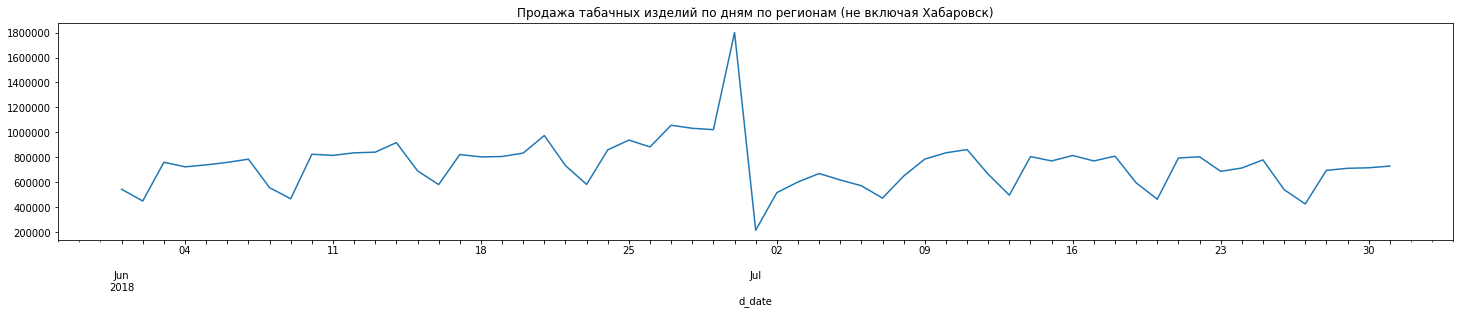

In [28]:
df_tabak_all = df.loc[(df.sig!='') & (df.cost<10e3) & (df['Имя региона']!='Хабаровский')].groupby(['d_date', 'receiptid'])['cost'].sum().reset_index().groupby('d_date')['cost'].sum()
ax = df_tabak_all.plot(figsize=(25,4), title="Продажа табачных изделий по дням по регионам (не включая Хабаровск)");
ax.set_xticks(df_tabak_all.index);

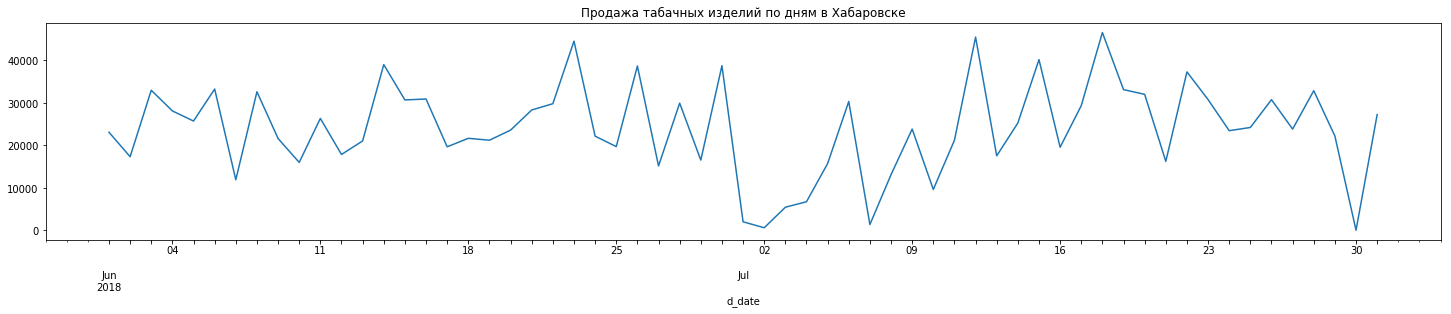

In [29]:
df_habar = df.loc[(df.sig!='') & (df.cost<10e5) & (df['Имя региона']=='Хабаровский')].groupby(['d_date', 'receiptid'])['cost'].sum().reset_index().groupby('d_date')['cost'].sum()
ax = df_habar.plot(figsize=(25,4), title="Продажа табачных изделий по дням в Хабаровске");
ax.set_xticks(df_habar.index);

Виден также спад после 30 июня 2018 как по Хабаровску так и по всем регионам. После скачка сумма продажи резко упала.
Возможно это как то связано с изменением акцизов на табак с 1 июля 2018 года или обязательным онлайн-кассам. Что интересно, отдельно по регионам спад в этот промежуток времени не прослеживается, тогда как по всем регионам вместе он есть

Посмотрим на бензин

In [30]:
df_benz = df.loc[(df.benz!='')].groupby(['Имя региона', 'receiptid']
                                           )['cost'].sum().reset_index().groupby(['Имя региона'])['cost'].agg({'min', np.median, 'max', 'sum'}
                                                                                                             ).sort_values('median', ascending=False).reset_index()
df_benz.head()

,Имя региона,min,sum,median,max
0,Самарская,45.00,1206089.88,99165.0,99990.0
1,Курская,97900.00,195800.00,97900.0,97900.0
2,Санкт-Петербург,50.00,1445150.00,95000.0,108000.0
3,Курганская,80809.42,260809.42,90000.0,90000.0
4,Москва,93.53,833578.53,25000.0,99750.0


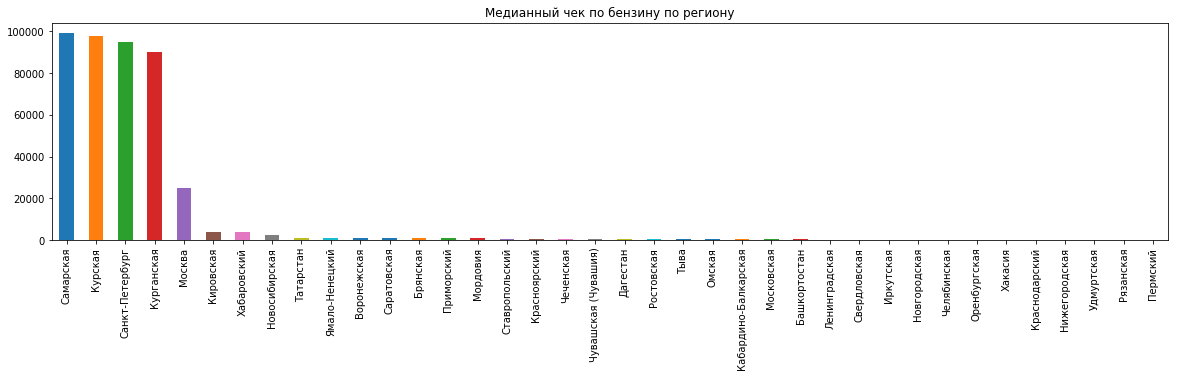

In [31]:
ax = df_benz['median'].plot(kind='bar', figsize=(20,4), title='Медианный чек по бензину по региону');
ax.set_xticks(df_benz.index);
ax.set_xticklabels(df_benz['Имя региона'], rotation=90);

Посмотрим на все регионы и на Самару

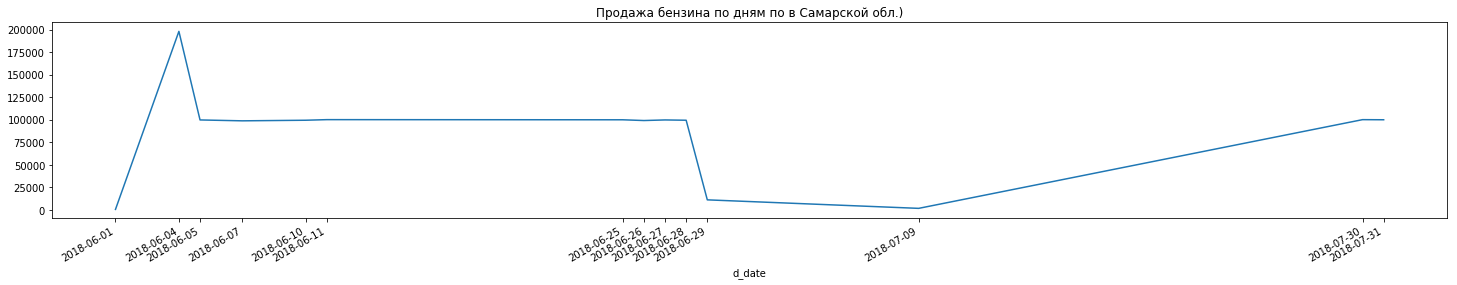

In [32]:
df_benz_all = df.loc[(df.benz!='') & (df['Имя региона']=='Самарская')].groupby(['d_date', 'receiptid'])['cost'].sum().reset_index().groupby('d_date')['cost'].sum()
ax = df_benz_all.plot(figsize=(25,4), title="Продажа бензина по дням по в Самарской обл.)");
ax.set_xticks(df_benz_all.index);

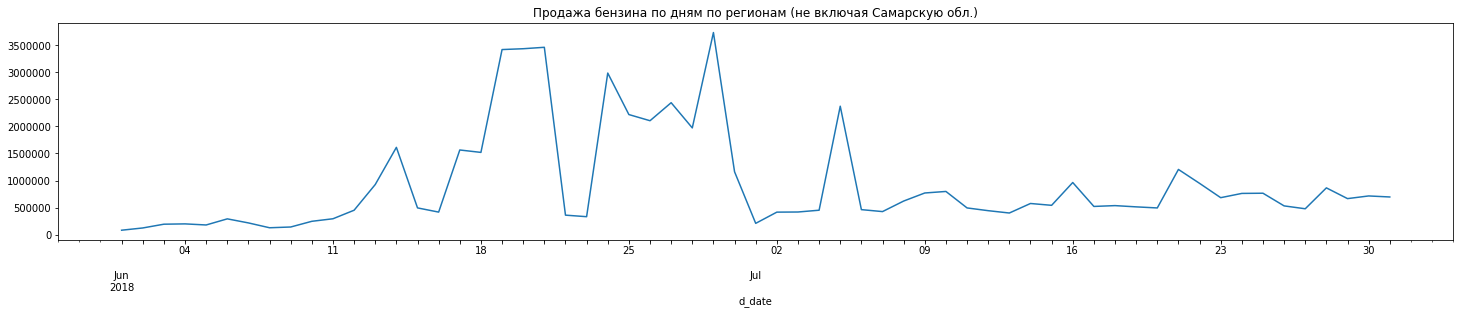

In [33]:
df_benz_all = df.loc[(df.benz!='')  & (df['Имя региона']!='Самарская')].groupby(['d_date', 'receiptid'])['cost'].sum().reset_index().groupby('d_date')['cost'].sum()
ax = df_benz_all.plot(figsize=(25,4), title="Продажа бензина по дням по регионам (не включая Самарскую обл.)");
ax.set_xticks(df_benz_all.index);

Видны пики продаж начиная со 2 половину июня и до начала июля по всем регионам

Посмотрим на пуховики

In [34]:
df_puh = df.loc[(df.puh!='')].groupby(['Имя региона', 'receiptid']
                                           )['cost'].sum().reset_index().groupby(['Имя региона'])['cost'].agg({'min', np.median, 'max', 'sum'}
                                                                                                             ).sort_values('median', ascending=False).reset_index()
df_puh.head()

,Имя региона,min,sum,median,max
0,Санкт-Петербург,11130.0,2134215.0,20930.0,60660.0
1,Приморский,4000.0,1025565.0,19005.0,61950.0
2,Хабаровский,900.0,242900.0,15000.0,18000.0
3,Ханты-Мансийский Автономный округ - Югра,4799.0,6302324.0,12277.0,33117.0
4,Тюменская,5498.0,2916865.0,10833.0,25576.0


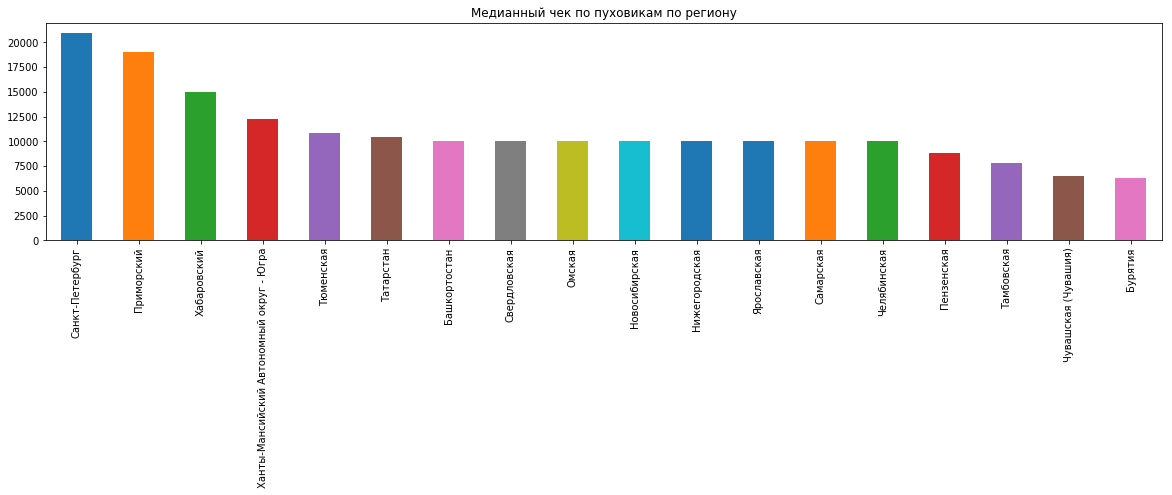

In [35]:
ax = df_puh['median'].plot(kind='bar', figsize=(20,4), title='Медианный чек по пуховикам по региону', rot=-10);
ax.set_xticks(df_puh.index);
ax.set_xticklabels(df_puh['Имя региона'], rotation=90);

Больше пуховиков покупали жители холодных регионов (Приморье, Хабаровск, ХМАО) и Санкт-Петербурга. Посмотрим продажи по дням

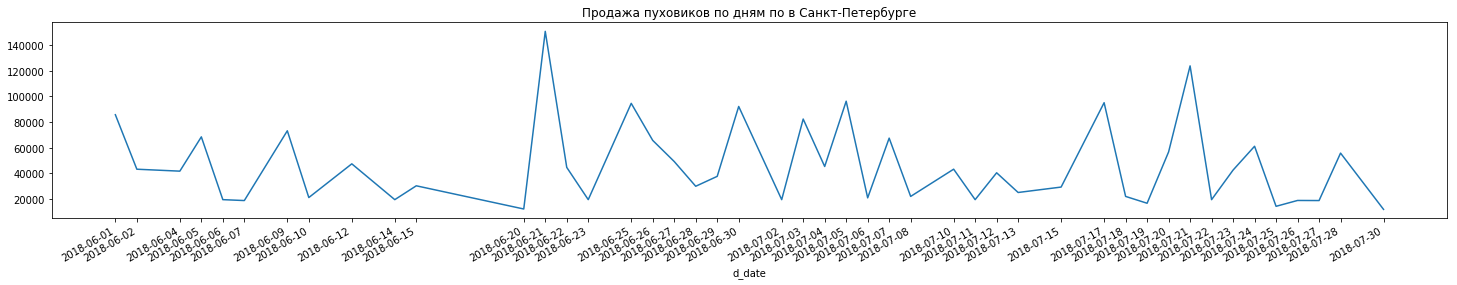

In [36]:
df_puh_all = df.loc[(df.puh!='') & (df['Имя региона']=='Санкт-Петербург')].groupby(['d_date', 'receiptid'])['cost'].sum().reset_index().groupby('d_date')['cost'].sum()
ax = df_puh_all.plot(figsize=(25,4), title="Продажа пуховиков по дням по в Санкт-Петербурге");
ax.set_xticks(df_puh_all.index);

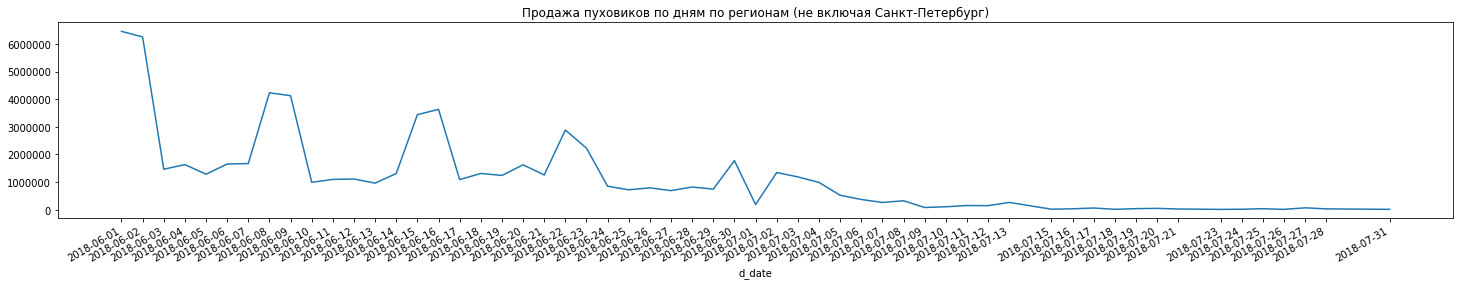

In [37]:
df_puh_all = df.loc[(df.puh!='') & (df['Имя региона']!='Санкт-Петербург')].groupby(['d_date', 'receiptid'])['cost'].sum().reset_index().groupby('d_date')['cost'].sum()
ax = df_puh_all.plot(figsize=(25,4), title="Продажа пуховиков по дням по регионам (не включая Санкт-Петербург)");
ax.set_xticks(df_puh_all.index);

Видно, что продажи пуховиков постепенно падают. Наложим все регионы:

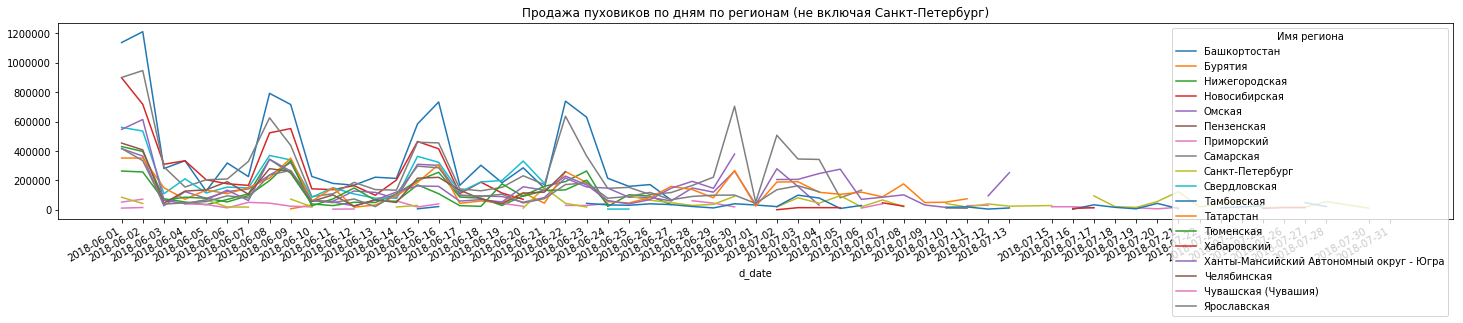

In [38]:
df_puh_all = df.loc[(df.puh!='')].groupby(['Имя региона', 'd_date', 'receiptid'])['cost'].sum().reset_index().groupby(['Имя региона', 'd_date'])['cost'].sum()
ax = pd.pivot_table(data=df_puh_all.reset_index()
                    , index='d_date', columns='Имя региона'
                    , values='cost').plot(figsize=(25,4)
                                          , title="Продажа пуховиков по дням по регионам (не включая Санкт-Петербург)");
ax.set_xticks(df_puh_all.reset_index()['d_date'].unique());

Видим одинаковые интервалы скачков продаж пуховиков по разным регионам. 